Acceptance rate: 0.2874
Times: [5353]
Average time: 5353.0
Estimated autocorrelation time: 216
m = 1.0, g = 0.5
v = 2.000
elementary mass = 1.414
rms displacement ~ 0.707
S_inst = 3.771 --> 1/p = 43.434
Final sample action: 26.631210327148438


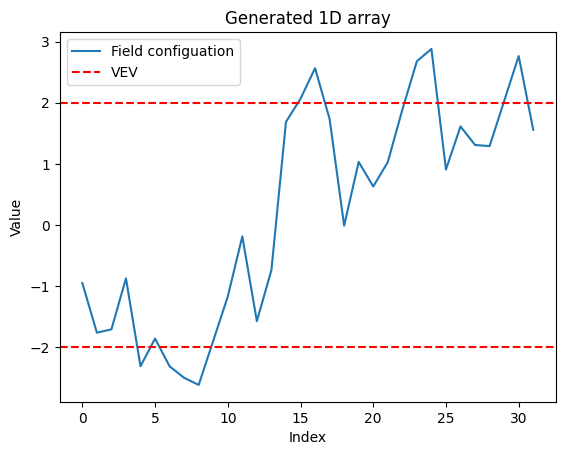

In [264]:
import torch
import matplotlib.pyplot as plt
import math

def action(x: torch.tensor, m: float, g: float):
    """
    Calculate the action of a scalar field on the lattice.
    
    Args:
    x (torch.Tensor): Input array.
    m (float): Mass term.
    g (float): Coupling constant for the potential term.
    
    Returns:
    float: Action of the scalar field.
    """
    gradient_term = torch.sum((x[1:] - x[:-1])**2 / 2)
    # potential_term = torch.sum(- m**2 * x**2 / 2 + g**2 * x**4 / 4)
    potential_term = torch.sum(g**2 / 4 * (x**2 - m**2 / g**2)**2)
    return gradient_term + potential_term

def metropolis_algorithm(size: int = 128, steps: int = 10000, m: float = 1.0, g: float = 1.0):
    """
    Metropolis algorithm to generate 1D arrays of given size based on a probability distribution function p.
    
    Args:
    p (function): Probability distribution function.
    size (int): Length of the 1D array.
    steps (int): Number of steps to run the algorithm.
    
    Returns:
    torch.Tensor: Generated 1D array.
    """
    # Initialize the array with random values
    # x = torch.randn(size, dtype=torch.float32)

    x = torch.randn(size, dtype=torch.float32) / math.sqrt(1 + m**2) + m / g
    x_sample = x.clone()


    sqrt_size = torch.tensor(size, dtype=torch.float32).sqrt()

    
    # keep track of acceptance rate
    accepted = 0
    time_since_last_sample = 0
    times = []
    samples = []
    for step in range(steps):
        
        # Propose a new value
        x_new = x.clone()

        # Choose a random index
        # i = torch.randint(0, size, (1,)).item()
        # x_new[i] += torch.randn(1).item()

        # Coefficient tuned to get an acceptance rate around 0.3
        x_new += 1.2 * torch.randn(size) / sqrt_size

        # Calculate the acceptance probability
        acceptance_prob = min(1, torch.exp(-action(x_new, m=m, g=g) + action(x, m=m, g=g)).item())
        
        # Accept or reject the new value
        if torch.rand(1).item() < acceptance_prob:
            x = x_new
            accepted += 1
            samples.append(x.clone())

            dot = torch.dot(x_sample, x)
            if dot < 0:
                x_sample = x.clone()
                times.append(time_since_last_sample)
                time_since_last_sample = 0
            else:
                time_since_last_sample += 1
    
    print(f"Acceptance rate: {accepted/steps}")
    # print(f"Average time between samples: {sum(times) / len(times)}")
    print('Times:', times)
    try:
        print('Average time:', sum(times) / len(times))
    except ZeroDivisionError:
        print('No samples')
    
    return x, torch.stack(samples)

def print_and_plot(generated_array, v):

    print(f'm = {m}, g = {g}')
    v = m / g
    print(f'v = {v:.3f}')
    print(f'elementary mass = {math.sqrt(2) * m:.3f}')
    print(f'rms displacement ~ {1 / math.sqrt(1 + m**2):.3f}')
    s_inst = 4 / 3 / math.sqrt(2) * m**3 / g**2
    print(f'S_inst = {s_inst:.3f} --> 1/p = {math.exp(s_inst):.3f}')
    print(f'Final sample action: {action(generated_array, m, g)}')

    # Plot the generated array as well as lines at plus and minus v
    plt.plot(generated_array, label='Field configuation')
    plt.axhline(y=v, color='r', linestyle='--', label='VEV')
    plt.axhline(y=-v, color='r', linestyle='--')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Generated 1D array')
    plt.show()

def autocorrelation(x):
    """
    Calculate the autocorrelation function of a 1D tensor.
    
    Args:
    x (torch.Tensor): Input tensor.
    
    Returns:
    torch.Tensor: Autocorrelation function.
    """
    n = len(x)
    x_mean = torch.mean(x)
    x_var = torch.var(x)
    autocorr = torch.zeros(n)
    
    for t in range(n):
        autocorr[t] = torch.sum((x[:n-t] - x_mean) * (x[t:] - x_mean)) / (n - t) / x_var # seems to be wrong
    
    return autocorr

def estimate_autocorrelation_time(samples):
    """
    Estimate the autocorrelation time from the generated samples.
    
    Args:
    samples (torch.Tensor): Generated samples.
    
    Returns:
    float: Estimated autocorrelation time.
    """
    autocorr = autocorrelation(samples)
    autocorr_time = torch.where(autocorr < torch.exp(torch.tensor(-1.0)))[0][0].item()
    return autocorr_time


# Generate 1D array using the Metropolis algorithm with the scalar field action
m=1.0
g=0.5
x, samples = metropolis_algorithm(size=32, steps=20000, m=m, g=g)
autocorr_time = estimate_autocorrelation_time(samples[:, 0])  # Use the first element of each sample
print(f"Estimated autocorrelation time: {autocorr_time}")
print_and_plot(x, m / g)

